# PyChe Tutorial: Run + Full Diagnostics

This notebook shows in-memory analysis from `res.mod` and `res.fis`, file-based diagnostics, and MPI launch commands.

In [1]:
from pyche import GCEModel, create_diagnostic_plots, read_outputs
from pyche.diagnostics import diagnostics_from_tables
import numpy as np
import matplotlib.pyplot as plt


## 1) In-memory run

In [2]:
m = GCEModel()
res = m.MinGCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=True,
    backend='auto',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
)
res.mod.shape, res.fis.shape


Progress [##############################] 100.00% (13700/13700)
MinGCE full translation run complete
ninputyield: 32
final gas: 495416.71295303036
final zeta: 0.0062633918211157345
timing profile (s): total=9.602, interp=7.618, mpi_reduce=0.000, death=0.523, wind=0.980, output=0.035, other=0.447
total runtime (wall): 9.602 s


((13700, 39), (13700, 12))

## 1b) Same run without approximations (baseline settings)

In [3]:
m = GCEModel()
res_noapprox = m.MinGCE(
    endoftime=13700,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=True,
    backend='auto',
    output_mode='dataframe',
    write_output=False,
    return_results=True,
    adaptive_timestep=False,
    interp_cache=False,
    interp_cache_guard=False,
    profile_timing=False,
    spalla_stride=1,
    spalla_inactive_threshold=0.0,
    spalla_lut=False,
)
res_noapprox.mod.shape, res_noapprox.fis.shape


Progress [##############################] 100.00% (13700/13700)
MinGCE full translation run complete
ninputyield: 32
final gas: 495745.9622989858
final zeta: 0.00625895498464687
total runtime (wall): 49.462 s


((13700, 39), (13700, 12))

## Output column names

In [4]:
print('mod columns:', res.mod_columns)
print('fis columns:', res.fis_columns)


mod columns: ('time', 'all', 'gas', 'stars', 'sfr', 'oldstars', 'HeN', 'C12', 'O16', 'N14', 'C13', 'Ne', 'Mg', 'Si', 'Fe', 'S14', 'C13S', 'S32', 'Ca', 'Remn', 'Zn', 'K', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Co', 'Ni', 'La', 'Ba', 'Eu', 'Sr', 'Y', 'Zr', 'Rb', 'Li', 'H', 'He4')
fis columns: ('time', 'all', 'gas', 'stars', 'remn', 'hot', 'zeta', 'sfr', 'nume', 'sfr2', 'snia_num', 'snia_rate')


## 2) Diagnostics from in-memory arrays

In [5]:
diag = diagnostics_from_tables(res.mod, res.fis)
diag


{'n_steps': 13700,
 'final_gas': 495416.71295303036,
 'final_stars': 377055.61466999975,
 'final_remn': 20864.700816725082,
 'final_zeta': 0.0062633918211157345,
 'max_sfr': 106.99587307155329,
 'checks': {'gas_nonnegative': True,
  'stars_nonnegative': True,
  'remn_nonnegative': True,
  'all_nonnegative': True},
 'all_checks_pass': True}

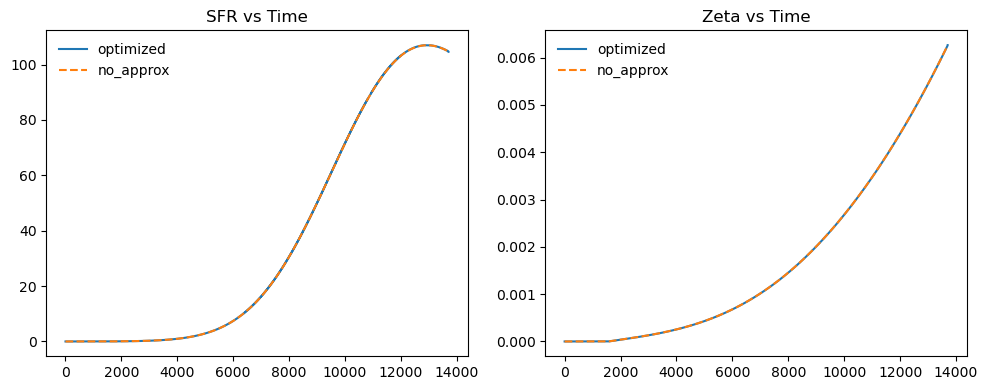

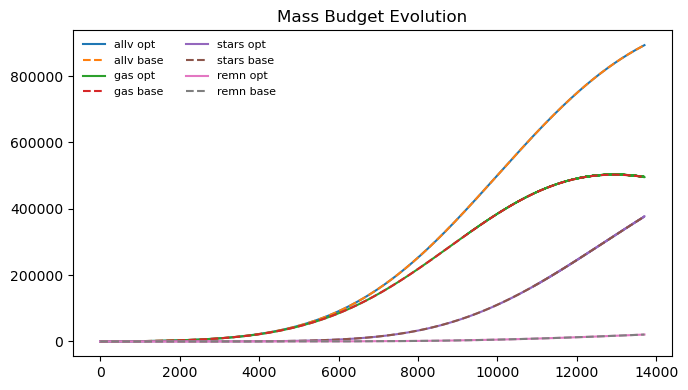

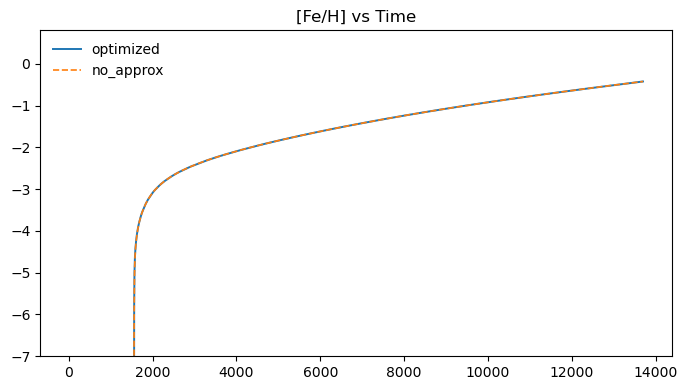

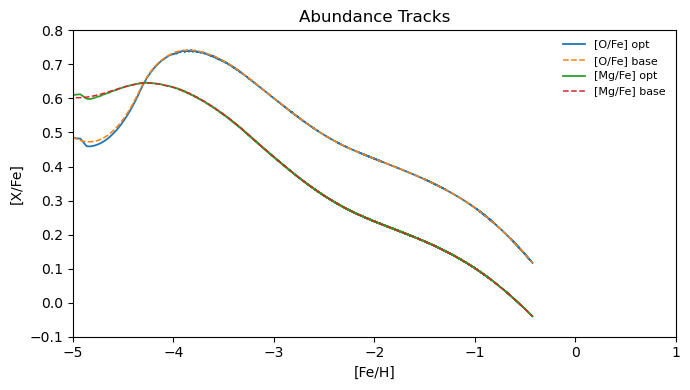

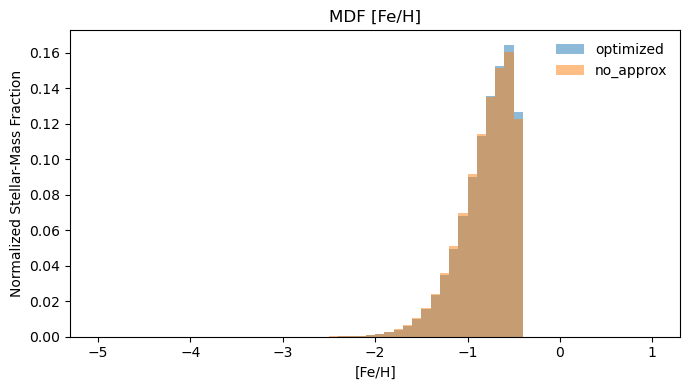

In [6]:
# Helper extractors for optimized run and no-approx run
mod_cols = {name: i for i, name in enumerate(res.mod_columns)}
fis_cols = {name: i for i, name in enumerate(res.fis_columns)}

def extract_series(r):
    time_f = r.fis[:, fis_cols['time']]
    sfr = r.fis[:, fis_cols['sfr']]
    allv = r.fis[:, fis_cols['all']]
    gas = r.fis[:, fis_cols['gas']]
    stars = r.fis[:, fis_cols['stars']]
    remn = r.fis[:, fis_cols['remn']]
    zeta = r.fis[:, fis_cols['zeta']]

    time_m = r.mod[:, mod_cols['time']]
    fe = r.mod[:, mod_cols['Fe']]
    h = r.mod[:, mod_cols['H']]
    o16 = r.mod[:, mod_cols['O16']]
    mg = r.mod[:, mod_cols['Mg']]

    eps = 1.0e-30
    FE_H_SUN_MASS = 56.0 * 10.0 ** (-4.50)
    O_FE_SUN_MASS = (16.0 / 56.0) * 10.0 ** (8.69 - 7.50)
    MG_FE_SUN_MASS = (24.305 / 56.0) * 10.0 ** (7.60 - 7.50)
    log_feh = np.log10(np.maximum(fe / np.maximum(h, eps), eps) / FE_H_SUN_MASS)
    log_o_fe = np.log10(np.maximum(o16 / np.maximum(fe, eps), eps) / O_FE_SUN_MASS)
    log_mg_fe = np.log10(np.maximum(mg / np.maximum(fe, eps), eps) / MG_FE_SUN_MASS)

    stars_delta = np.diff(stars, prepend=stars[0])
    stars_delta = np.maximum(stars_delta, 0.0)
    mdf_mask = np.isfinite(log_feh) & (log_feh >= -5.0) & (log_feh <= 1.0)

    return {
        'time_f': time_f, 'sfr': sfr, 'allv': allv, 'gas': gas, 'stars': stars, 'remn': remn, 'zeta': zeta,
        'time_m': time_m, 'log_feh': log_feh, 'log_o_fe': log_o_fe, 'log_mg_fe': log_mg_fe,
        'stars_delta': stars_delta, 'mdf_mask': mdf_mask,
    }

opt = extract_series(res)
base = extract_series(res_noapprox)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(opt['time_f'], opt['sfr'], label='optimized')
ax[0].plot(base['time_f'], base['sfr'], '--', label='no_approx')
ax[0].set_title('SFR vs Time')
ax[0].legend(frameon=False)
ax[1].plot(opt['time_f'], opt['zeta'], label='optimized')
ax[1].plot(base['time_f'], base['zeta'], '--', label='no_approx')
ax[1].set_title('Zeta vs Time')
ax[1].legend(frameon=False)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 4))
for name in ['allv','gas','stars','remn']:
    ax.plot(opt['time_f'], opt[name], label=f'{name} opt')
    ax.plot(base['time_f'], base[name], '--', label=f'{name} base')
ax.set_title('Mass Budget Evolution')
ax.legend(frameon=False, ncols=2, fontsize=8)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(opt['time_m'], opt['log_feh'], lw=1.4, label='optimized')
ax.plot(base['time_m'], base['log_feh'], '--', lw=1.2, label='no_approx')
ax.set_title('[Fe/H] vs Time')
ax.set_ylim(-7,0.8)
ax.legend(frameon=False)
plt.tight_layout()

mask_opt = np.isfinite(opt['log_feh'])
mask_base = np.isfinite(base['log_feh'])
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(opt['log_feh'][mask_opt], opt['log_o_fe'][mask_opt], label='[O/Fe] opt', lw=1.3)
ax.plot(base['log_feh'][mask_base], base['log_o_fe'][mask_base], '--', label='[O/Fe] base', lw=1.1)
ax.plot(opt['log_feh'][mask_opt], opt['log_mg_fe'][mask_opt], label='[Mg/Fe] opt', lw=1.3)
ax.plot(base['log_feh'][mask_base], base['log_mg_fe'][mask_base], '--', label='[Mg/Fe] base', lw=1.1)
ax.set_title('Abundance Tracks')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[X/Fe]')
ax.set_xlim(-5,1)
ax.set_ylim(-0.1,0.8)
ax.legend(frameon=False, fontsize=8)
plt.tight_layout()

bins = np.linspace(-5, 1, 61)
w_opt = opt['stars_delta'][opt['mdf_mask']].copy()
w_base = base['stars_delta'][base['mdf_mask']].copy()
if np.sum(w_opt) > 0:
    w_opt /= np.sum(w_opt)
if np.sum(w_base) > 0:
    w_base /= np.sum(w_base)
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(opt['log_feh'][opt['mdf_mask']], bins=bins, weights=w_opt, alpha=0.5, label='optimized')
ax.hist(base['log_feh'][base['mdf_mask']], bins=bins, weights=w_base, alpha=0.5, label='no_approx')
ax.set_title('MDF [Fe/H]')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Normalized Stellar-Mass Fraction')
ax.legend(frameon=False)
plt.tight_layout()


## 3) Save a run, load it back, and create plot files

In [ ]:
out_dir = 'RISULTATI_PYCHE_NOTEBOOK'
m.MinGCE(
    endoftime=1000,
    sigmat=3000.0,
    sigmah=50.0,
    psfr=0.3,
    pwind=0.0,
    delay=10000,
    time_wind=10000,
    use_mpi=False,
    show_progress=False,
    output_dir=out_dir,
    output_mode='dataframe',
    df_binary_format='pickle',
    write_output=True,
    return_results=False,
)
payload = read_outputs(out_dir, prefer='dataframe', binary_format='pickle')
payload['mod'].shape, payload['fis'].shape, payload['format']


In [ ]:
paths = create_diagnostic_plots(out_dir, prefer='dataframe', binary_format='pickle')
paths


## 4) MPI run example with 4 ranks

Run from shell (outside notebook):

```bash
mpiexec -n 4 python -c "from pyche import GCEModel; m=GCEModel(); m.MinGCE(13700,3000.0,50.0,0.3,0.0,10000,10000,use_mpi=True,show_progress=False,backend='auto',output_dir='RISULTATI_MPI4',output_mode='dataframe',df_binary_format='pickle')"
```

With Cython backend (compile first):

```bash
pip install cython
python setup.py build_ext --inplace
mpiexec -n 4 python -c "from pyche import GCEModel; m=GCEModel(); m.MinGCE(13700,3000.0,50.0,0.3,0.0,10000,10000,use_mpi=True,show_progress=False,backend='cython',output_dir='RISULTATI_MPI4_CY',output_mode='dataframe',df_binary_format='pickle')"
```